# 머신 러닝 교과서 - 파이토치편

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/ml-with-pytorch/blob/main/ch03/ch03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 패키지 버전 체크

check_packages.py 스크립트에서 로드하기 위해 폴더를 추가합니다:

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 python_environment_check.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
else:
    sys.path.insert(0, '..')

In [2]:
import sys
sys.path.append('..')  # 상위 디렉토리 추가

from python_environment_check import check_packages

[OK] Your Python version is 3.11.12 (main, Apr  9 2025, 04:03:34) [MSC v.1943 64 bit (AMD64)]


권장 패키지 버전을 확인하세요:

In [3]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
    'pandas': '1.3.2'
}
check_packages(d)

[OK] numpy 2.2.6
[OK] matplotlib 3.10.3
[OK] sklearn 1.6.1
[OK] pandas 2.2.3


# 한글 주석 설정

In [4]:
import matplotlib.pyplot as plt 
# 한글출력
plt.rcParams['font.family'] = 'Malgun Gothic' # MacOS 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#  3장 - 사이킷런을 타고 떠나는 머신 러닝 분류 모델 투어

### 목차


- 분류 알고리즘 선택
- 사이킷런 첫걸음: 퍼셉트론 훈련
- 로지스틱 회귀를 사용한 클래스 확률 모델링
  - 로지스틱 회귀의 이해와 조건부 확률
  - 로지스틱 손실 함수의 가중치 학습
  - 아달린 구현을 로지스틱 회귀 알고리즘으로 변경
  - 사이킷런을 사용하여 로지스틱 회귀 모델 훈련
  - 규제를 사용하여 과대적합 피하기
- 서포트 벡터 머신을 사용한 최대 마진 분류
  - 최대 마진
  - 슬랙 변수를 사용하여 비선형 분류 문제 다루기
  - 사이킷런의 다른 구현
- 커널 SVM을 사용하여 비선형 문제 풀기
  - 선형적으로 구분되지 않는 데이터를 위한 커널 방법
  - 커널 기법을 사용하여 고차원 공간에서 분할 초평면 찾기
- 결정 트리 학습
  - 정보 이득 최대화: 자원을 최대로 활용
  - 결정 트리 만들기
  - 랜덤 포레스트로 여러 개의 결정 트리 연결
- k-최근접 이웃: 게으른 학습 알고리즘
- 요약

In [5]:
from IPython.display import Image
%matplotlib inline

# 분류 알고리즘 선택

# 사이킷런 첫걸음: 퍼셉트론 훈련


사이킷런에서 붓꽃 데이터셋을 적재합니다. 세 번째 열은 꽃잎의 길이이고 네 번째 열은 꽃잎의 너비입니다. 클래스는 이미 정수 레이블로 변환되어 있습니다. 0=Iris-Setosa, 1=Iris-Versicolor, 2=Iris-Virginica 입니다.

In [6]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('클래스 레이블:', np.unique(y))

클래스 레이블: [0 1 2]


70%는 훈련 데이터 30%는 테스트 데이터로 분할합니다:

In [7]:
# 데이터를 훈련 세트와 테스트 세트로 분할
from sklearn.model_selection import train_test_split

# X: 특성 데이터, y: 레이블 데이터
# test_size=0.3: 테스트 세트 비율 30%
# random_state=1: 재현 가능성을 위한 랜덤 시드
# stratify=y: 계층적 샘플링으로 클래스 비율 유지
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [8]:
# 전체 데이터셋의 클래스별 샘플 개수 출력
print('y의 레이블 카운트:', np.bincount(y))
# 훈련 데이터셋의 클래스별 샘플 개수 출력
print('y_train의 레이블 카운트:', np.bincount(y_train))
# 테스트 데이터셋의 클래스별 샘플 개수 출력
print('y_test의 레이블 카운트:', np.bincount(y_test))

y의 레이블 카운트: [50 50 50]
y_train의 레이블 카운트: [35 35 35]
y_test의 레이블 카운트: [15 15 15]


특성을 표준화합니다:

In [9]:
# StandardScaler를 사용하여 특성 표준화
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
sc = StandardScaler()
# 훈련 데이터로 스케일러 학습
sc.fit(X_train)
# 훈련 데이터와 테스트 데이터를 표준화
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## 사이킷런 첫걸음: 퍼셉트론 훈련

In [10]:
# 퍼셉트론 모델 임포트
from sklearn.linear_model import Perceptron

# 퍼셉트론 모델 객체 생성
# eta0=0.1: 학습률 설정
# random_state=1: 재현 가능성을 위한 랜덤 시드
ppn = Perceptron(eta0=0.1, random_state=1)

# 퍼셉트론 모델 학습
# X_train_std: 표준화된 훈련 데이터
# y_train: 훈련 레이블
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [11]:
# 테스트 데이터에 대한 예측 수행
y_pred = ppn.predict(X_test_std)

# 실제 레이블과 예측값이 다른 샘플의 개수 출력
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())

잘못 분류된 샘플 개수: 1


In [12]:
# 정확도 측정을 위한 accuracy_score 임포트
from sklearn.metrics import accuracy_score

# 테스트 데이터의 실제 레이블과 예측값을 비교하여 정확도 출력
print('정확도: %.3f' % accuracy_score(y_test, y_pred))

정확도: 0.978


In [13]:
print('정확도: %.3f' % ppn.score(X_test_std, y_test))

정확도: 0.978


In [14]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# 맷플롯립 호환성 확인
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    """
    결정 경계를 시각화하는 함수
    
    매개변수:
    X: 특성 행렬
    y: 클래스 레이블
    classifier: 분류기 객체
    test_idx: 테스트 데이터 인덱스
    resolution: 결정 경계의 해상도
    """

    # 마커와 컬러맵 설정
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그리기 위한 그리드 생성
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # 그리드 포인트에 대한 예측 수행
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    
    # 결정 경계 그리기
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 각 클래스별 샘플 시각화
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'클래스 {cl}',
                    edgecolor='black')

    # 테스트 샘플 강조 표시
    if test_idx:
        # 테스트 데이터 추출
        X_test, y_test = X[test_idx, :], y[test_idx]

        # 테스트 샘플 시각화
        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100,
                    label='테스트 세트')

표준화한 훈련 데이터를 사용해 퍼셉트론 모델을 훈련합니다:

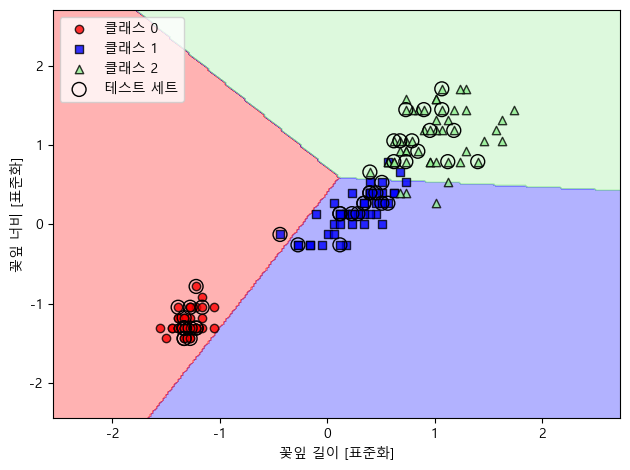

In [15]:
# 훈련 데이터와 테스트 데이터를 결합
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# 결정 경계 시각화
plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('꽃잎 길이 [표준화]')
plt.ylabel('꽃잎 너비 [표준화]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/03_01.png', dpi=300)
plt.show()

# 로지스틱 회귀를 사용한 클래스 확률 모델링


### 로지스틱 회귀의 이해와 조건부 확률


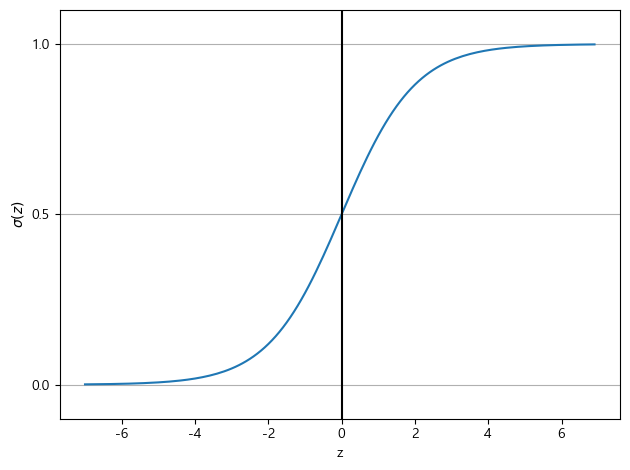

In [16]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(z):
    """
    시그모이드 활성화 함수를 계산합니다.
    
    Parameters:
    z : float or array-like
        입력값
        
    Returns:
    float or array-like
        0과 1 사이의 시그모이드 함수값
    """
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
sigma_z = sigmoid(z)

plt.plot(z, sigma_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)$')

# y축 눈금과 격자선 설정
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
#plt.savefig('figures/03_02.png', dpi=300)
plt.show()

In [17]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch03/figures/03_03.png', width=500)

In [18]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch03/figures/03_25.png', width=500)

### 로지스틱 손실 함수의 가중치 학습


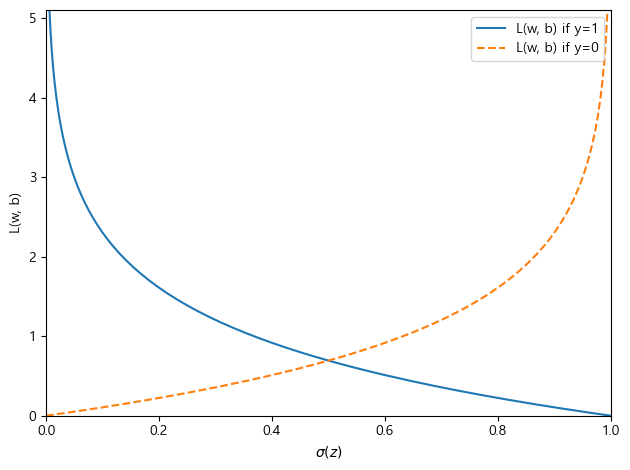

In [19]:
# loss_1(z): y=1일 때의 로지스틱 손실 함수
# -log(σ(z)) 형태로, 예측값이 1에 가까울수록 손실이 작아짐
def loss_1(z):
    return - np.log(sigmoid(z))

# loss_0(z): y=0일 때의 로지스틱 손실 함수
# -log(1-σ(z)) 형태로, 예측값이 0에 가까울수록 손실이 작아짐
def loss_0(z):
    return - np.log(1 - sigmoid(z))

# -10부터 10까지 0.1 간격으로 z값 생성
z = np.arange(-10, 10, 0.1)
# z값에 대한 시그모이드 함수값 계산
sigma_z = sigmoid(z)

# y=1일 때의 손실값 계산 및 그래프 그리기
c1 = [loss_1(x) for x in z]
plt.plot(sigma_z, c1, label='L(w, b) if y=1')

# y=0일 때의 손실값 계산 및 그래프 그리기 (점선으로 표시)
c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle='--', label='L(w, b) if y=0')

# y축 범위 설정 (0.0 ~ 5.1)
plt.ylim(0.0, 5.1)
# x축 범위 설정 (0 ~ 1)
plt.xlim([0, 1])
# x축 레이블 설정 (시그모이드 함수값)
plt.xlabel('$\sigma(z)$')
# y축 레이블 설정 (손실 함수값)
plt.ylabel('L(w, b)')
# 범례 위치 자동 설정
plt.legend(loc='best')
# 그래프 여백 자동 조정
plt.tight_layout()
#plt.savefig('figures/03_04.png', dpi=300)
# 그래프 표시
plt.show()

### 아달린 구현을 로지스틱 회귀 알고리즘으로 변경

In [20]:
class LogisticRegressionGD:
    """경사 하강법을 사용한 로지스틱 회귀 분류기

    이 클래스는 로지스틱 회귀를 구현한 것으로, 경사 하강법을 사용하여 이진 분류 문제를 해결합니다.
    시그모이드 함수를 활성화 함수로 사용하여 0과 1 사이의 확률값을 출력하고,
    이 확률값을 기반으로 클래스를 예측합니다.

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
      - 너무 크면 최적해를 지나칠 수 있음
      - 너무 작으면 학습이 느려질 수 있음
    n_iter : int
      훈련 데이터셋 반복 횟수
      - 전체 데이터셋을 한 번 학습하는 것을 1 에포크라고 함
      - 에포크 수가 많을수록 더 정확한 학습이 가능하나 과적합 위험도 증가
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드
      - 재현 가능한 결과를 위해 사용

    속성
    -----------
    w_ : 1d-array
      학습된 가중치 벡터
      - 각 특성에 대한 중요도를 나타냄
      - 크기가 클수록 해당 특성이 예측에 더 큰 영향을 미침
    b_ : 스칼라
      학습된 절편 유닛 (편향)
      - 결정 경계의 위치를 조정하는 역할
    losses_ : list
      각 에포크의 로지스틱 손실 함수 값
      - 학습 과정에서 손실이 어떻게 변화하는지 추적
      - 손실이 감소하는 것을 확인하여 학습이 잘 되고 있는지 모니터링

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        """클래스 초기화
        
        기본값으로 학습률 0.01, 반복 횟수 50, 시드값 1을 사용합니다.
        """
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        경사 하강법을 사용하여 로지스틱 회귀 모델을 학습합니다.
        각 에포크마다:
        1. 순전파를 통해 예측값 계산
        2. 예측값과 실제값의 차이(오차) 계산
        3. 오차를 기반으로 가중치와 편향 업데이트
        4. 현재 손실값 계산 및 저장

        매개변수
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
          - 각 행은 하나의 샘플을 나타냄
          - 각 열은 하나의 특성을 나타냄
        y : array-like, shape = [n_samples]
          타깃값 (0 또는 1)
          - 이진 분류 문제를 가정

        반환값
        -------
        self : object
          학습된 모델 인스턴스 반환
        """
        rgen = np.random.RandomState(self.random_state)
        # 가중치 초기화: 평균 0, 표준편차 0.01인 정규분포에서 무작위 추출
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # 편향 초기화: 0으로 설정
        self.b_ = np.float64(0.)
        # 손실값을 저장할 리스트 초기화
        self.losses_ = []

        for i in range(self.n_iter):
            # 순전파: 가중치와 입력의 선형 결합
            net_input = self.net_input(X)
            # 활성화 함수를 통과시켜 확률값 계산
            output = self.activation(net_input)
            # 오차 계산: 실제값 - 예측값
            errors = (y - output)
            # 가중치 업데이트: 학습률 * 입력값과 오차의 곱의 평균
            self.w_ += self.eta * X.T.dot(errors) / X.shape[0]
            # 편향 업데이트: 학습률 * 오차의 평균
            self.b_ += self.eta * errors.mean()
            # 로지스틱 손실 함수 계산
            loss = (-y.dot(np.log(output)) - (1 - y).dot(np.log(1 - output))) / X.shape[0]
            # 손실값 저장
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """최종 입력 계산
        
        가중치와 입력의 선형 결합에 편향을 더한 값을 계산합니다.
        z = w^T * x + b 형태의 계산을 수행합니다.
        """
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        """로지스틱 시그모이드 활성화 계산
        
        시그모이드 함수를 사용하여 입력값을 0과 1 사이의 확률값으로 변환합니다.
        수치적 안정성을 위해 입력값을 -250과 250 사이로 제한합니다.
        """
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """클래스 레이블 예측
        
        활성화 함수의 출력값이 0.5 이상이면 1, 미만이면 0으로 예측합니다.
        이는 이진 분류 문제에서 일반적으로 사용되는 임계값입니다.
        """
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

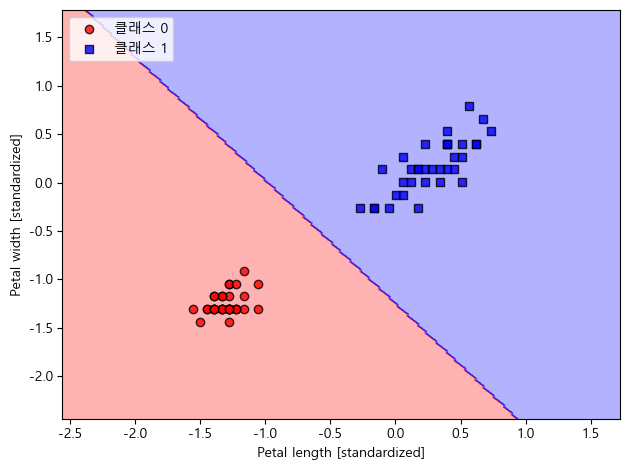

In [21]:
# 클래스 0과 1에 해당하는 데이터만 선택하여 이진 분류 문제로 변환
# X_train_std에서 y_train이 0 또는 1인 샘플만 선택
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
# y_train에서 0 또는 1인 레이블만 선택
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

# 로지스틱 회귀 모델 초기화
# eta: 학습률 (0.3)
# n_iter: 최대 반복 횟수 (1000)
# random_state: 난수 생성 시드 (1)
lrgd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
# 선택된 데이터로 모델 학습
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

# 결정 경계 시각화
# X: 학습 데이터
# y: 학습 레이블
# classifier: 학습된 분류기
plot_decision_regions(X=X_train_01_subset,
                      y=y_train_01_subset,
                      classifier=lrgd)

# x축 레이블 설정: 표준화된 꽃잎 길이
plt.xlabel('Petal length [standardized]')
# y축 레이블 설정: 표준화된 꽃잎 너비
plt.ylabel('Petal width [standardized]')
# 범례 위치 설정: 왼쪽 상단
plt.legend(loc='upper left')

# 그래프 레이아웃 자동 조정
plt.tight_layout()
# 그래프 저장 (주석 처리됨)
#plt.savefig('figures/03_05.png', dpi=300)
# 그래프 표시
plt.show()

### 사이킷런을 사용하여 로지스틱 회귀 모델 훈련


C:\Users\Admin\Desktop\lgu6p_ml_dl\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


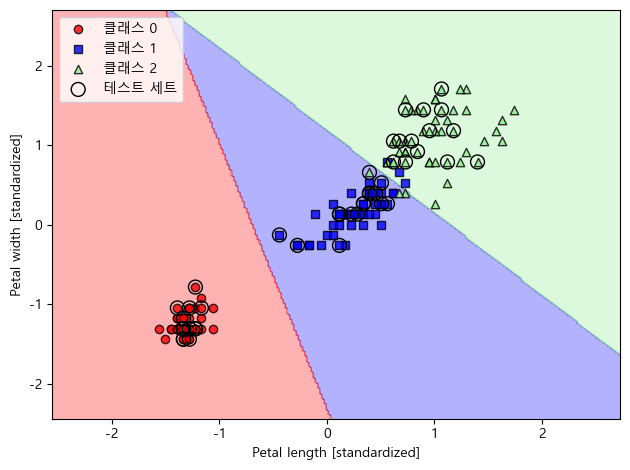

In [22]:
# 사이킷런의 로지스틱 회귀 모델 임포트
from sklearn.linear_model import LogisticRegression

# 로지스틱 회귀 모델 초기화
# C: 규제 강도의 역수 (100.0) - 값이 클수록 규제가 약해짐
# solver: 최적화 알고리즘 ('lbfgs') - Limited-memory BFGS 알고리즘 사용
# multi_class: 다중 클래스 분류 방식 ('ovr') - One-vs-Rest 방식 사용
lr = LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr')

# 표준화된 학습 데이터로 모델 학습
lr.fit(X_train_std, y_train)

# 결정 경계 시각화
# X_combined_std: 표준화된 전체 데이터셋
# y_combined: 전체 레이블
# classifier: 학습된 로지스틱 회귀 모델
# test_idx: 테스트 데이터 인덱스 (105-149)
plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))

# x축 레이블 설정: 표준화된 꽃잎 길이
plt.xlabel('Petal length [standardized]')
# y축 레이블 설정: 표준화된 꽃잎 너비
plt.ylabel('Petal width [standardized]')
# 범례 위치 설정: 왼쪽 상단
plt.legend(loc='upper left')

# 그래프 레이아웃 자동 조정
plt.tight_layout()
# 그래프 저장 (주석 처리됨)
#plt.savefig('figures/03_06.png', dpi=300)
# 그래프 표시
plt.show()

In [23]:
# 로지스틱 회귀 모델을 사용하여 테스트 데이터의 처음 3개 샘플에 대한 클래스별 확률 예측
# X_test_std[:3, :]: 표준화된 테스트 데이터의 처음 3개 샘플
# predict_proba(): 각 클래스에 속할 확률을 반환 (0~1 사이의 값)
lr.predict_proba(X_test_std[:3, :])

array([[6.63770505e-09, 1.44747233e-01, 8.55252760e-01],
       [8.34031210e-01, 1.65968790e-01, 3.20815954e-13],
       [8.48822884e-01, 1.51177116e-01, 2.57998350e-14]])

In [24]:
# 로지스틱 회귀 모델의 예측 확률 합계 계산
# X_test_std[:3, :]: 표준화된 테스트 데이터의 처음 3개 샘플
# predict_proba(): 각 클래스에 속할 확률을 반환 (0~1 사이의 값)
# sum(axis=1): 각 샘플별로 모든 클래스의 확률을 합산 (행 방향으로 합산)
# 결과는 각 샘플에 대한 모든 클래스의 확률 합이 1이 되는지 확인
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [25]:
# 로지스틱 회귀 모델을 사용하여 테스트 데이터의 처음 3개 샘플에 대한 예측 확률 중 최대값을 가진 클래스 인덱스 반환
# X_test_std[:3, :]: 표준화된 테스트 데이터의 처음 3개 샘플
# predict_proba(): 각 클래스에 속할 확률을 반환 (0~1 사이의 값)
# argmax(axis=1): 각 샘플별로 가장 높은 확률을 가진 클래스의 인덱스를 반환 (행 방향으로 최대값 인덱스)
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In [26]:
# 로지스틱 회귀 모델을 사용하여 테스트 데이터의 처음 3개 샘플에 대한 클래스 예측
# X_test_std[:3, :]: 표준화된 테스트 데이터의 처음 3개 샘플
# predict(): 각 샘플에 대해 가장 높은 확률을 가진 클래스 레이블을 반환
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [27]:
# 로지스틱 회귀 모델을 사용하여 테스트 데이터의 첫 번째 샘플에 대한 클래스 예측
# X_test_std[0, :]: 표준화된 테스트 데이터의 첫 번째 샘플
# reshape(1, -1): 1행 n열의 2차원 배열로 변환 (scikit-learn의 predict 메서드는 2차원 배열 입력 필요)
# predict(): 가장 높은 확률을 가진 클래스 레이블을 반환
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

### 규제를 사용하여 과대적합 피하기

In [28]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch03/figures/03_07.png', width=700)

C:\Users\Admin\Desktop\lgu6p_ml_dl\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Admin\Desktop\lgu6p_ml_dl\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Admin\Desktop\lgu6p_ml_dl\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Admin\Desktop\lgu6p_ml_dl\.venv\Lib\site-packages\sk

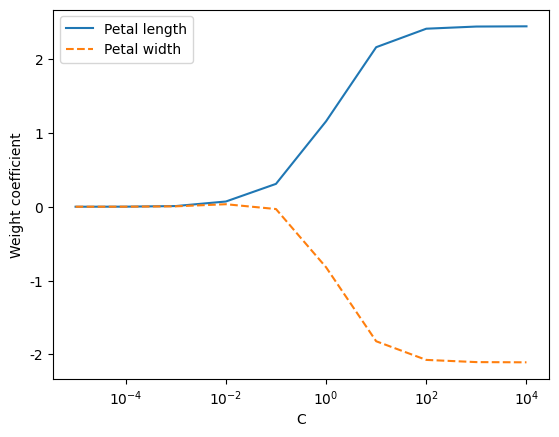

In [29]:
# plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'    # 유니코드 지원
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# 가중치와 규제 파라미터를 저장할 빈 리스트 초기화
weights, params = [], []

# 규제 강도 C의 역수인 10^(-5)부터 10^4까지 반복
for c in np.arange(-5, 5):
    # 로지스틱 회귀 모델 생성
    # C=10.**c: 규제 강도 설정 (C가 작을수록 규제가 강함)
    # multi_class='ovr': One-vs-Rest 방식으로 다중 클래스 분류 수행
    lr = LogisticRegression(C=10.**c,
                            multi_class='ovr')
    # 표준화된 훈련 데이터로 모델 학습
    lr.fit(X_train_std, y_train)
    # 두 번째 클래스에 대한 가중치 계수 저장 (coef_[1])
    weights.append(lr.coef_[1])
    # 현재 규제 파라미터 값 저장
    params.append(10.**c)

# 가중치 리스트를 numpy 배열로 변환
weights = np.array(weights)

# 꽃잎 길이에 대한 가중치 계수 그래프 그리기
plt.plot(params, weights[:, 0],
         label='Petal length')
# 꽃잎 너비에 대한 가중치 계수 그래프 그리기 (점선)
plt.plot(params, weights[:, 1], linestyle='--',
         label='Petal width')
# y축 레이블 설정
plt.ylabel('Weight coefficient')
# x축 레이블 설정
plt.xlabel('C')
# 범례 위치 설정 (왼쪽 상단)
plt.legend(loc='upper left')
# x축을 로그 스케일로 설정
plt.xscale('log')
# 그래프 저장 (주석 처리됨)
#plt.savefig('figures/03_08.png', dpi=300)
# 그래프 표시
plt.show()

# 서포트 벡터 머신을 사용한 최대 마진 분류


In [30]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch03/figures/03_09.png', width=700)

## 최대 마진


## 슬랙 변수를 사용하여 비선형 분류 문제 다루기


In [31]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch03/figures/03_10.png', width=600)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18008\2492948434.py:34: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_18008\2492948434.py:34: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_18008\2492948434.py:34: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_18008\2492948434.py:34: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_18008\2492948434.py:34: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_18008\2492948434.py:34: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from

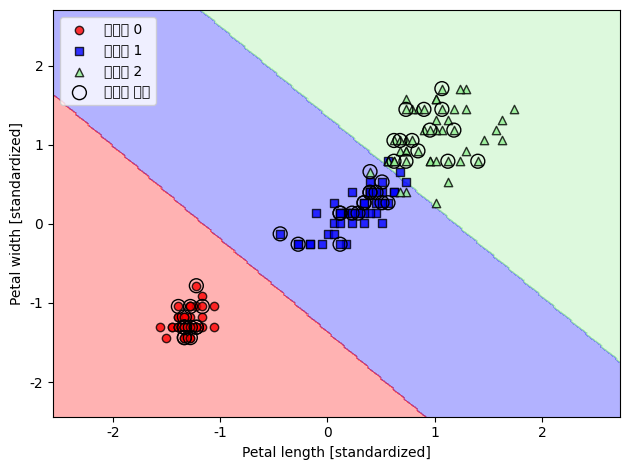

In [32]:
# scikit-learn에서 SVM(Support Vector Machine) 분류기 임포트
from sklearn.svm import SVC

# 선형 커널을 사용하는 SVM 분류기 생성
# kernel='linear': 선형 결정 경계를 사용하는 커널 함수
# C=1.0: 규제 매개변수로, 오분류에 대한 패널티 강도를 조절
#   - C가 클수록 마진이 좁아지고 오분류에 대한 패널티가 커짐
#   - C가 작을수록 마진이 넓어지고 오분류에 대한 패널티가 작아짐
# random_state=1: 재현 가능한 결과를 위한 랜덤 시드 설정
svm = SVC(kernel='linear', C=1.0, random_state=1)

# 표준화된 훈련 데이터로 SVM 모델 학습
# X_train_std: 표준화된 특성 데이터 (평균 0, 표준편차 1)
# y_train: 클래스 레이블
svm.fit(X_train_std, y_train)

# 결정 경계 시각화 함수 호출
# X_combined_std: 표준화된 특성 데이터 (훈련+테스트)
# y_combined: 클래스 레이블 (훈련+테스트)
# classifier=svm: 학습된 SVM 분류기
# test_idx=range(105, 150): 테스트 데이터 인덱스 (105-149)
plot_decision_regions(X_combined_std,
                      y_combined,
                      classifier=svm,
                      test_idx=range(105, 150))

# x축 레이블 설정 (표준화된 꽃잎 길이)
plt.xlabel('Petal length [standardized]')
# y축 레이블 설정 (표준화된 꽃잎 너비)
plt.ylabel('Petal width [standardized]')
# 범례 위치 설정 (왼쪽 상단)
plt.legend(loc='upper left')
# 그래프 레이아웃 자동 조정 (여백 최적화)
plt.tight_layout()
# 그래프 저장 (주석 처리됨)
#plt.savefig('figures/03_11.png', dpi=300)
# 그래프 표시
plt.show()

## 사이킷런의 다른 구현


In [33]:
# scikit-learn의 SGDClassifier 임포트
# SGDClassifier: 확률적 경사 하강법(Stochastic Gradient Descent)을 사용하는 분류기
from sklearn.linear_model import SGDClassifier

# 퍼셉트론 분류기 생성
# loss='perceptron': 퍼셉트론 손실 함수 사용
# - 퍼셉트론은 이진 분류를 위한 가장 단순한 선형 분류기
# - 마진이 0보다 크면 손실이 0, 그렇지 않으면 선형적으로 증가
ppn = SGDClassifier(loss='perceptron')

# 로지스틱 회귀 분류기 생성
# loss='log': 로지스틱 손실 함수 사용
# - 로지스틱 회귀는 이진 분류를 위한 확률적 분류기
# - 시그모이드 함수를 사용하여 클래스 확률을 계산
lr = SGDClassifier(loss='log')

# 선형 SVM 분류기 생성
# loss='hinge': 힌지 손실 함수 사용
# - SVM은 마진을 최대화하는 분류기
# - 힌지 손실은 마진이 1보다 작을 때 선형적으로 증가
svm = SGDClassifier(loss='hinge')

# 커널 SVM을 사용하여 비선형 문제 풀기


## 선형적으로 구분되지 않는 데이터를 위한 커널 방법

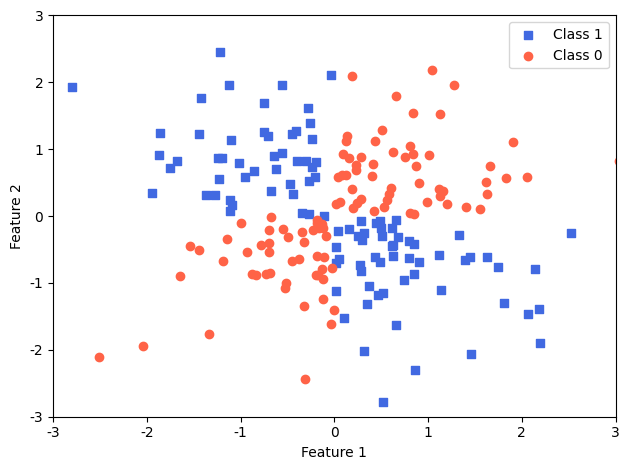

In [34]:
# 필요한 라이브러리 임포트
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리
import numpy as np  # 수치 계산을 위한 라이브러리

# 난수 생성을 위한 시드 설정 (재현성을 위해)
np.random.seed(1)

# XOR 데이터셋 생성
# 200개의 2차원 데이터 포인트를 정규분포에서 무작위로 생성
X_xor = np.random.randn(200, 2)

# XOR 연산을 사용하여 레이블 생성
# 첫 번째 특성이 0보다 크고 두 번째 특성이 0보다 작거나,
# 첫 번째 특성이 0보다 작고 두 번째 특성이 0보다 큰 경우를 Class 1로 설정
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
# 논리값을 0과 1로 변환
y_xor = np.where(y_xor, 1, 0)

# Class 1 데이터 포인트 시각화
# 파란색 사각형 마커로 표시
plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='royalblue',
            marker='s',
            label='Class 1')

# Class 0 데이터 포인트 시각화
# 빨간색 원형 마커로 표시
plt.scatter(X_xor[y_xor == 0, 0],
            X_xor[y_xor == 0, 1],
            c='tomato',
            marker='o',
            label='Class 0')

# x축 범위 설정 (-3에서 3까지)
plt.xlim([-3, 3])
# y축 범위 설정 (-3에서 3까지)
plt.ylim([-3, 3])

# x축 레이블 설정
plt.xlabel('Feature 1')
# y축 레이블 설정
plt.ylabel('Feature 2')

# 범례 표시 (최적의 위치에 자동 배치)
plt.legend(loc='best')
# 그래프 레이아웃 자동 조정
plt.tight_layout()

# 그래프 저장 (현재는 주석 처리됨)
#plt.savefig('figures/03_12.png', dpi=300)

# 그래프 표시
plt.show()

In [35]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch03/figures/03_13.png', width=700)

## 커널 기법을 사용하여 고차원 공간에서 분할 초평면 찾기


C:\Users\Admin\AppData\Local\Temp\ipykernel_18008\1832870850.py:22: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_18008\1832870850.py:22: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_18008\1832870850.py:22: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\Desktop\lgu6p_ml_dl\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\Desktop\lgu6p_ml_dl\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\Desktop\lgu6p_ml_dl\.venv

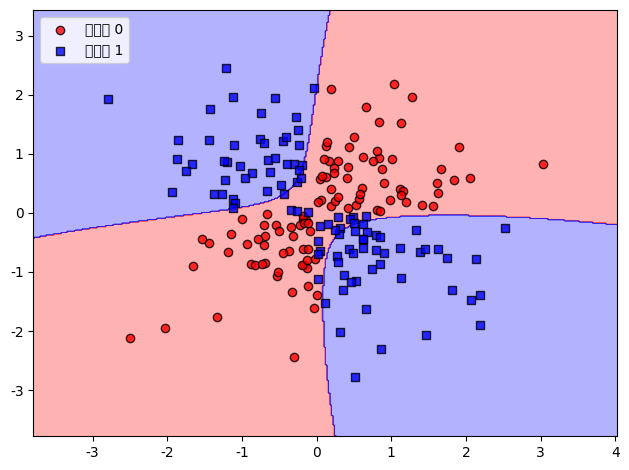

In [36]:
# RBF(Radial Basis Function) 커널을 사용하는 SVM 모델 생성
# - kernel='rbf': RBF 커널 사용 (비선형 결정 경계를 만들 수 있음)
# - random_state=1: 재현 가능한 결과를 위한 랜덤 시드 설정
# - gamma=0.10: RBF 커널의 복잡도 조절 매개변수 (값이 클수록 결정 경계가 더 구불구불해짐)
# - C=10.0: 규제 매개변수 (값이 클수록 마진이 좁아지고 오버피팅 가능성 증가)
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)

# XOR 데이터셋으로 SVM 모델 학습
svm.fit(X_xor, y_xor)

# 결정 경계와 데이터 포인트를 시각화
# - X_xor: 특성 데이터
# - y_xor: 클래스 레이블
# - classifier=svm: 학습된 SVM 모델
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

# 범례를 그래프의 왼쪽 상단에 배치
plt.legend(loc='upper left')

# 그래프 레이아웃 자동 조정 (여백 최적화)
plt.tight_layout()

# 그래프를 파일로 저장 (현재는 주석 처리됨)
#plt.savefig('figures/03_14.png', dpi=300)

# 그래프 표시
plt.show()

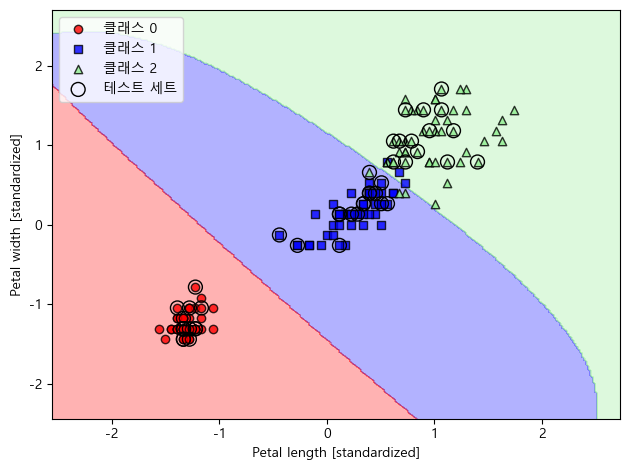

In [37]:
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정
# plt.rcParams['font.family'] = 'DejaVu Sans'    # 유니코드 지원
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# scikit-learn에서 SVM 분류기 임포트
from sklearn.svm import SVC

# SVM 모델 생성 및 하이퍼파라미터 설정
# - kernel='rbf': RBF(Radial Basis Function) 커널 사용하여 비선형 결정 경계 생성
# - random_state=1: 재현 가능한 결과를 위한 랜덤 시드 설정
# - gamma=0.2: RBF 커널의 복잡도 조절 매개변수 (값이 클수록 결정 경계가 더 구불구불해짐)
# - C=1.0: 규제 매개변수 (값이 클수록 마진이 좁아지고 오버피팅 가능성 증가)
svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)

# 표준화된 훈련 데이터로 SVM 모델 학습
svm.fit(X_train_std, y_train)

# 결정 경계와 데이터 포인트를 시각화
# - X_combined_std: 표준화된 전체 특성 데이터
# - y_combined: 전체 클래스 레이블
# - classifier=svm: 학습된 SVM 모델
# - test_idx=range(105, 150): 테스트 데이터 인덱스 범위 지정
plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))

# x축 레이블 설정 (표준화된 꽃잎 길이)
plt.xlabel('Petal length [standardized]')

# y축 레이블 설정 (표준화된 꽃잎 너비)
plt.ylabel('Petal width [standardized]')

# 범례를 그래프의 왼쪽 상단에 배치
plt.legend(loc='upper left')

# 그래프 레이아웃 자동 조정 (여백 최적화)
plt.tight_layout()

# 그래프를 파일로 저장 (현재는 주석 처리됨)
#plt.savefig('figures/03_15.png', dpi=300)

# 그래프 표시
plt.show()

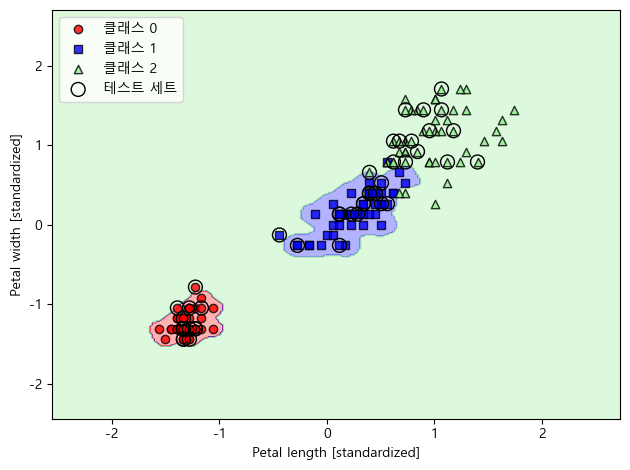

In [38]:
# SVM 모델 생성 및 하이퍼파라미터 설정
# - kernel='rbf': RBF(Radial Basis Function) 커널 사용하여 비선형 결정 경계 생성
# - random_state=1: 재현 가능한 결과를 위한 랜덤 시드 설정
# - gamma=100.0: RBF 커널의 복잡도 조절 매개변수 (이전보다 매우 큰 값으로 설정하여 결정 경계가 더욱 구불구불해짐)
# - C=1.0: 규제 매개변수 (값이 클수록 마진이 좁아지고 오버피팅 가능성 증가)
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)

# 표준화된 훈련 데이터로 SVM 모델 학습
svm.fit(X_train_std, y_train)

# 결정 경계와 데이터 포인트를 시각화
# - X_combined_std: 표준화된 전체 특성 데이터
# - y_combined: 전체 클래스 레이블
# - classifier=svm: 학습된 SVM 모델
# - test_idx=range(105, 150): 테스트 데이터 인덱스 범위 지정
plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))

# x축 레이블 설정 (표준화된 꽃잎 길이)
plt.xlabel('Petal length [standardized]')

# y축 레이블 설정 (표준화된 꽃잎 너비)
plt.ylabel('Petal width [standardized]')

# 범례를 그래프의 왼쪽 상단에 배치
plt.legend(loc='upper left')

# 그래프 레이아웃 자동 조정 (여백 최적화)
plt.tight_layout()

# 그래프를 파일로 저장 (현재는 주석 처리됨)
#plt.savefig('figures/03_16.png', dpi=300)

# 그래프 표시
plt.show()

# 결정 트리 학습


In [39]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch03/figures/03_17.png', width=500)

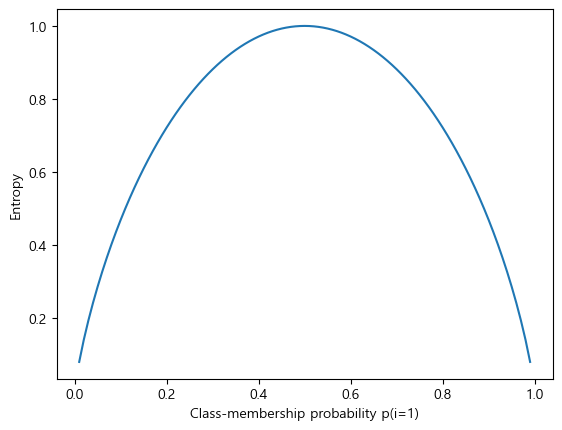

In [40]:
# 엔트로피 계산 함수 정의
# p: 클래스 멤버십 확률 (0~1 사이의 값)
# 반환값: 엔트로피 값 (불확실성의 측정값)
# - p가 0이나 1에 가까울수록 엔트로피는 낮아짐 (불확실성 감소)
# - p가 0.5에 가까울수록 엔트로피는 높아짐 (불확실성 증가)
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))

# 0부터 1까지 0.01 간격으로 확률값 생성
x = np.arange(0.0, 1.0, 0.01)

# 각 확률값에 대한 엔트로피 계산
# p가 0인 경우 None으로 처리 (로그 계산 불가)
ent = [entropy(p) if p != 0 else None
       for p in x]

# y축 레이블 설정 (엔트로피)
plt.ylabel('Entropy')

# x축 레이블 설정 (클래스 멤버십 확률)
plt.xlabel('Class-membership probability p(i=1)')

# 엔트로피 곡선 플롯
plt.plot(x, ent)

# 그래프를 파일로 저장 (현재는 주석 처리됨)
#plt.savefig('figures/03_26.png', dpi=300)

# 그래프 표시
plt.show()

In [41]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch03/figures/03_18.png', width=500)

## 정보 이득 최대화: 자원을 최대로 활용


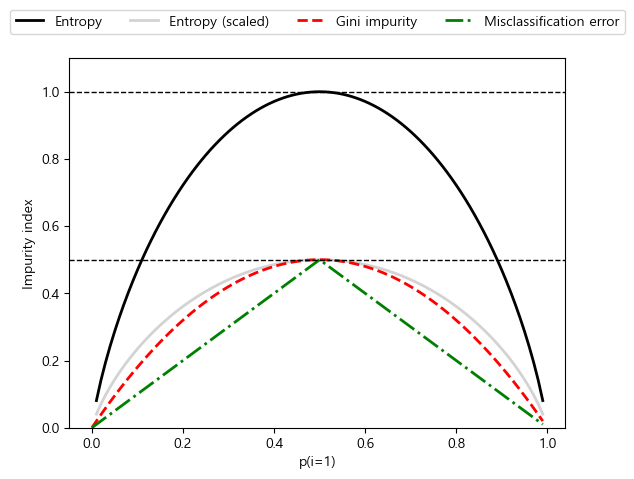

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# 지니 불순도(Gini Impurity) 계산 함수
# p: 클래스 멤버십 확률 (0~1 사이의 값)
# 반환값: 지니 불순도 값
# - p가 0이나 1에 가까울수록 지니 불순도는 낮아짐 (순수도 증가)
# - p가 0.5에 가까울수록 지니 불순도는 높아짐 (순수도 감소)
def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))

# 엔트로피(Entropy) 계산 함수
# p: 클래스 멤버십 확률 (0~1 사이의 값)
# 반환값: 엔트로피 값
# - p가 0이나 1에 가까울수록 엔트로피는 낮아짐 (불확실성 감소)
# - p가 0.5에 가까울수록 엔트로피는 높아짐 (불확실성 증가)
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))

# 오분류 오차(Misclassification Error) 계산 함수
# p: 클래스 멤버십 확률 (0~1 사이의 값)
# 반환값: 오분류 오차 값
# - p가 0이나 1에 가까울수록 오분류 오차는 낮아짐
# - p가 0.5에 가까울수록 오분류 오차는 높아짐
def error(p):
    return 1 - np.max([p, 1 - p])

# 0부터 1까지 0.01 간격으로 확률값 생성
x = np.arange(0.0, 1.0, 0.01)

# 각 확률값에 대한 엔트로피 계산
# p가 0인 경우 None으로 처리 (로그 계산 불가)
ent = [entropy(p) if p != 0 else None for p in x]

# 엔트로피 값을 0.5배로 스케일링
sc_ent = [e * 0.5 if e else None for e in ent]

# 각 확률값에 대한 오분류 오차 계산
err = [error(i) for i in x]

# 새로운 그래프 생성
fig = plt.figure()
ax = plt.subplot(111)

# 각 불순도 지표를 그래프에 플롯
# zip을 사용하여 여러 리스트를 동시에 순회
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                          ['Entropy', 'Entropy (scaled)',
                           'Gini impurity', 'Misclassification error'],
                          ['-', '-', '--', '-.'],  # 선 스타일
                          ['black', 'lightgray', 'red', 'green', 'cyan']):  # 선 색상
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

# 범례 설정
# upper center: 그래프 상단 중앙에 위치
# bbox_to_anchor: 범례의 위치를 미세 조정
# ncol: 범례를 5열로 표시
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

# 수평선 추가 (y=0.5와 y=1.0)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')

# y축 범위 설정 (0부터 1.1까지)
plt.ylim([0, 1.1])

# 축 레이블 설정
plt.xlabel('p(i=1)')  # x축: 클래스 멤버십 확률
plt.ylabel('Impurity index')  # y축: 불순도 지표

# 그래프 표시
plt.show()

## 결정 트리 만들기


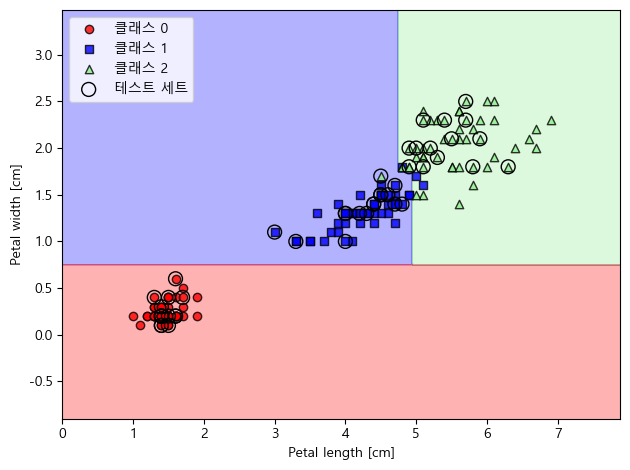

In [43]:
# scikit-learn의 결정 트리 분류기 임포트
from sklearn.tree import DecisionTreeClassifier

# 결정 트리 모델 생성 및 매개변수 설정
# criterion='gini': 불순도 측정 지표로 지니 불순도 사용
# max_depth=4: 트리의 최대 깊이를 4로 제한하여 과적합 방지
# random_state=1: 재현 가능한 결과를 위한 랜덤 시드 설정
tree_model = DecisionTreeClassifier(criterion='gini',
                                    max_depth=4,
                                    random_state=1)

# 학습 데이터로 모델 학습
tree_model.fit(X_train, y_train)

# 훈련 데이터와 테스트 데이터를 결합하여 전체 데이터셋 생성
# np.vstack: 수직으로 배열을 쌓음 (특성 데이터)
# np.hstack: 수평으로 배열을 쌓음 (레이블 데이터)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

# 결정 경계 시각화
# plot_decision_regions 함수를 사용하여 결정 경계와 데이터 포인트 표시
# test_idx: 테스트 데이터의 인덱스 범위 지정 (105-149)
plot_decision_regions(X_combined, y_combined,
                      classifier=tree_model,
                      test_idx=range(105, 150))

# 그래프 레이블 및 범례 설정
plt.xlabel('Petal length [cm]')  # x축: 꽃잎 길이
plt.ylabel('Petal width [cm]')   # y축: 꽃잎 너비
plt.legend(loc='upper left')     # 범례 위치: 좌측 상단
plt.tight_layout()               # 그래프 레이아웃 자동 조정

# 그래프 저장 (주석 처리됨)
#plt.savefig('figures/03_20.png', dpi=300)

# 그래프 표시
plt.show()

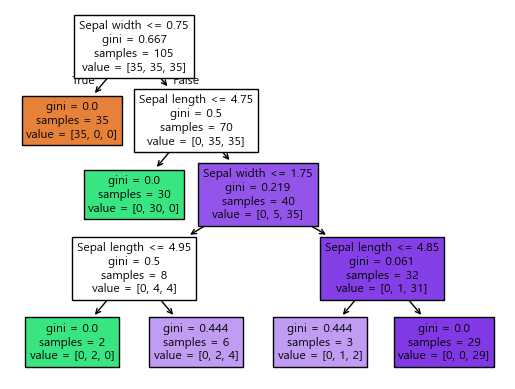

In [44]:
# scikit-learn의 tree 모듈에서 결정 트리 시각화 기능 임포트
from sklearn import tree

# 특성(Feature) 이름을 리스트로 정의
# 꽃의 4가지 특성: 꽃받침 길이, 꽃받침 너비, 꽃잎 길이, 꽃잎 너비
feature_names = ['Sepal length', 'Sepal width',
                 'Petal length', 'Petal width']

# 결정 트리 시각화
# tree_model: 이전에 학습된 결정 트리 모델
# feature_names: 각 노드에서 사용된 특성의 이름을 표시
# filled=True: 노드를 클래스 레이블에 따라 색상으로 채움
tree.plot_tree(tree_model,
               feature_names=feature_names,
               filled=True)

# 그래프를 PDF 파일로 저장 (현재는 주석 처리됨)
#plt.savefig('figures/03_21_1.pdf')

# 시각화된 결정 트리 그래프를 화면에 표시
plt.show()

## 랜덤 포레스트로 여러 개의 결정 트리 연결


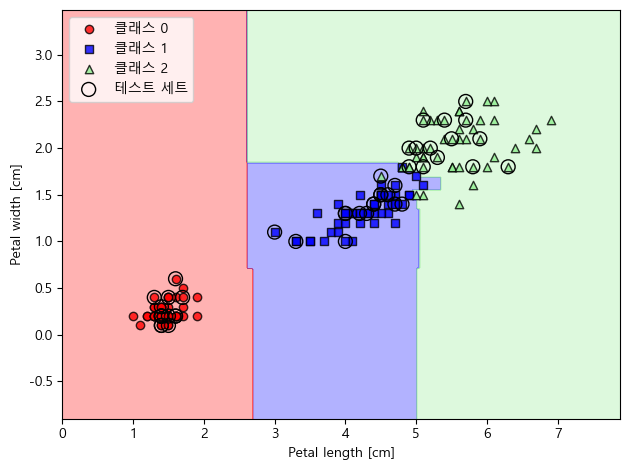

In [45]:
# scikit-learn의 ensemble 모듈에서 RandomForestClassifier 임포트
# RandomForestClassifier는 여러 개의 결정 트리를 앙상블하여 예측하는 분류기
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier 객체 생성 및 주요 매개변수 설정
# n_estimators=25: 앙상블에 사용할 결정 트리의 개수를 25개로 설정
# random_state=1: 재현 가능한 결과를 위한 난수 시드 설정
# n_jobs=2: 병렬 처리를 위해 2개의 CPU 코어 사용
forest = RandomForestClassifier(n_estimators=25,
                              random_state=1,
                              n_jobs=2)

# 학습 데이터(X_train)와 레이블(y_train)을 사용하여 랜덤 포레스트 모델 학습
forest.fit(X_train, y_train)

# 결정 경계 시각화 함수를 사용하여 학습된 랜덤 포레스트 모델의 결정 영역 표시
# X_combined: 전체 특성 데이터
# y_combined: 전체 레이블 데이터
# classifier=forest: 시각화할 분류기로 랜덤 포레스트 모델 지정
# test_idx=range(105, 150): 테스트 데이터로 사용할 인덱스 범위 지정
plot_decision_regions(X_combined, y_combined,
                     classifier=forest, test_idx=range(105, 150))

# 그래프의 x축 레이블 설정: 꽃잎 길이(cm)
plt.xlabel('Petal length [cm]')
# 그래프의 y축 레이블 설정: 꽃잎 너비(cm)
plt.ylabel('Petal width [cm]')
# 범례를 그래프의 좌측 상단에 배치
plt.legend(loc='upper left')
# 그래프 레이아웃 자동 조정
plt.tight_layout()
# 그래프를 파일로 저장 (현재는 주석 처리됨)
#plt.savefig('figures/03_2.png', dpi=300)
# 그래프 화면에 표시
plt.show()

# k-최근접 이웃: 게으른 학습 알고리즘


In [46]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch03/figures/03_23.png', width=400)

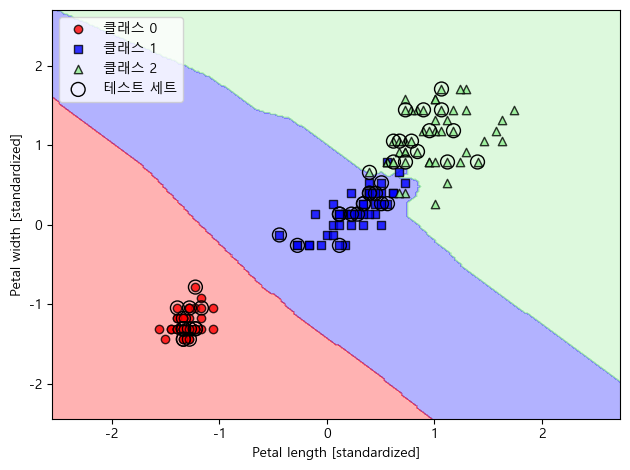

In [47]:
# scikit-learn의 neighbors 모듈에서 KNeighborsClassifier 임포트
# KNeighborsClassifier는 k-최근접 이웃 알고리즘을 구현한 분류기
from sklearn.neighbors import KNeighborsClassifier

# KNeighborsClassifier 객체 생성 및 주요 매개변수 설정
# n_neighbors=5: 분류에 사용할 이웃의 수를 5개로 설정
# p=2: 거리 측정에 사용할 거리 지표의 차수를 2로 설정 (유클리드 거리)
# metric='minkowski': 거리 측정 방법으로 민코프스키 거리 사용
knn = KNeighborsClassifier(n_neighbors=5,
                           p=2,
                           metric='minkowski')

# 표준화된 학습 데이터(X_train_std)와 레이블(y_train)을 사용하여 k-최근접 이웃 모델 학습
knn.fit(X_train_std, y_train)

# 결정 경계 시각화 함수를 사용하여 학습된 k-최근접 이웃 모델의 결정 영역 표시
# X_combined_std: 표준화된 전체 특성 데이터
# y_combined: 전체 레이블 데이터
# classifier=knn: 시각화할 분류기로 k-최근접 이웃 모델 지정
# test_idx=range(105, 150): 테스트 데이터로 사용할 인덱스 범위 지정
plot_decision_regions(X_combined_std, y_combined,
                      classifier=knn, test_idx=range(105, 150))

# 그래프의 x축 레이블 설정: 표준화된 꽃잎 길이
plt.xlabel('Petal length [standardized]')
# 그래프의 y축 레이블 설정: 표준화된 꽃잎 너비
plt.ylabel('Petal width [standardized]')
# 범례를 그래프의 좌측 상단에 배치
plt.legend(loc='upper left')
# 그래프 레이아웃 자동 조정
plt.tight_layout()
# 그래프를 파일로 저장 (현재는 주석 처리됨)
#plt.savefig('figures/03_24_figures.png', dpi=300)
# 그래프 화면에 표시
plt.show()

# 요약